### Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import time
import matplotlib.ticker as ticker

In [2]:
import importlib
import Utils_models
importlib.reload(Utils_models)
from Utils_models import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Load models and evaluate with filters to make a more specific evaluation. Find out if a model is performing better on filtered data than on the average of all test dataset.

### Load Model Classes

In [4]:
import Models_Classes
importlib.reload(Models_Classes)
from Models_Classes import MLPBaseline
from Models_Classes import EncDec_Noise
from Models_Classes import EncDec_Noise_1
from Models_Classes import LSTM
from Models_Classes import LSTM_Pooling
from Models_Classes import TrajTransformer

### Initialize Dataoader - Regular

In [5]:
from Models_Classes import LoadCSV_to_Dataset

In [6]:
features_xy_cords = ['xCenter', 'yCenter']  # x and y coordinates
features_zones =    ['zone_zebra', 'zone_1', 'zone_2', 'zone_3']
features_ttc_123 =      ['ttc_1', 'ttc_2', 'ttc_3']
features_ttc_456 =      ['ttc_4', 'ttc_5', 'ttc_6']
features_ttc_789 =      ['ttc_7', 'ttc_8', 'ttc_9']
features_ttc = features_ttc_123 + features_ttc_456 + features_ttc_789

input_features = features_xy_cords   + features_zones  + features_ttc    # input all features
# input_features = features_xy_cords                                       # input only xy


output_features = features_xy_cords                                     # out
# dimensions
input_dim = len(input_features)     # 2 + 4 + 9 = 15
output_dim = len(output_features)    # 2

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_path = r'C:\Users\yftac\Documents\00_Project_Afeka\ttc_calculation\13_data_tcc_flattened'

obs_input_len=8        # 8 history
fut_output_len=12       # 12 horizon
batch_size=64

dataset = LoadCSV_to_Dataset(folder_path, obs_input_len, fut_output_len, 
                             input_features, output_features)   # loads csv's

# split for train-test
train_size = int(0.8 * len(dataset)) # split_percentage = 0.8
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size],
                                           generator=torch.Generator().manual_seed(42))
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False) # for reproduecibility
test_dataloader = DataLoader(test_dataset,   batch_size, shuffle=False)

## Load saved models

In [8]:
### dim=2  ------------------------------------------------------------------------------

# file_name_EncDec_Noise = "EncDec_Noise_xy_epoch_50_h-h_8-12.pth"
# model_EncDec_Noise, checkpoint_EncDec_Noise = load_model(file_name_EncDec_Noise, 
#                                                              EncDec_Noise, device)

# file_name_EncDec_Noise = "EncDec_Noise_xy_epoch_500_h-h_8-12_penalty_false.pth"
# model_EncDec_Noise, checkpoint_EncDec_Noise = load_model(file_name_EncDec_Noise, 
#                                                              EncDec_Noise, device)

# file_name_LSTM = "LSTM_xy_epoch_20_h-h_8-12.pth"
# model_LSTM, checkpoint_LSTM = load_model(file_name_LSTM, LSTM, device)

# file_name_LSTM = "LSTM_xy_epoch_140_h-h_8-12_pt1_pf1.2.pth"
# model_LSTM, checkpoint_LSTM = load_model(file_name_LSTM, LSTM, device)

# file_name_LSTM = "LSTM_xy_epoch_40_h-h_8-12.pth"
# model_LSTM, checkpoint_LSTM = load_model(file_name_LSTM, LSTM, device)


### dim=15  ------------------------------------------------------------------------------

# file_name_EncDec_Noise_1 = "EncDec_Noise_1_xy_zone_ttc_epoch_50_h-h_8-12.pth"
# model_EncDec_Noise_1, checkpoint_EncDec_Noise_1 = load_model(file_name_EncDec_Noise_1, 
#                                                              EncDec_Noise_1, device)

# file_name_LSTM = "LSTM_xy_zone_ttc_epoch_40_h-h_8-12.pth"
# model_LSTM, checkpoint_LSTM = load_model(file_name_LSTM, LSTM, device)

# file_name_LSTM_Pooling = "LSTM_Pooling_xy_zone_ttc_epoch_20_h-h_8-12.pth"
# model_LSTM_Pooling, checkpoint_LSTM_Pooling = load_model(file_name_LSTM_Pooling, 
#                                                          LSTM_Pooling, device)

file_name_LSTM_Pooling = "LSTM_Pooling_xy_zone_ttc_epoch_140_h-h_8-12_pt1_pf1.2.pth"
model_LSTM_Pooling, checkpoint_LSTM_Pooling = load_model(file_name_LSTM_Pooling, 
                                                         LSTM_Pooling, device)

# file_name_TrajTransformer = "TrajTransformer_xy_zone_ttc_epoch_20_h-h_8-12.pth"
# model_TrajTransformer, checkpoint_TrajTransformer = load_model(file_name_TrajTransformer, 
#                                                          TrajTransformer, device)

Loaded and switch to eval: LSTM_Pooling_xy_zone_ttc_epoch_140_h-h_8-12_pt1_pf1.2.pth


c:\Users\yftac\Documents\00_Project_Afeka\models\v2\Utils_models.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_name, map_location=device)

In [9]:
### Print all hyperparameters of a defined model

# print('model_MLPBaseline:\n',get_model_hyperparameters(model_MLPBaseline))
# print('\nmodel_EncDec_Noise:\n',get_model_hyperparameters(model_EncDec_Noise))
# print('\nmodel_EncDec_Noise_1:\n',get_model_hyperparameters(model_EncDec_Noise_1))
# print('\nmodel_LSTM:\n',get_model_hyperparameters(model_LSTM))
# print('\nmodel_LSTM_Pooling:\n',get_model_hyperparameters(model_LSTM_Pooling))
# print('\nmodel_TrajTransformer:\n',get_model_hyperparameters(model_TrajTransformer))

# loss_history=checkpoint_EncDec_Noise['loss_history']
# obs_len = checkpoint_EncDec_Noise['obs_len']
# pred_len = checkpoint_EncDec_Noise['pred_len']
# lr = checkpoint_EncDec_Noise['lr']
# checkpoint_EncDec_Noise_1['loss_history']
# checkpoint_LSTM['loss_history']
# checkpoint_LSTM_Pooling['loss_history']
# checkpoint_TrajTransformer['loss_history']

# plot training
# plot_title_detailes =(f"obs_len: {obs_len}, pred_len: {pred_len}, epochs: {len(loss_history)}, lr: {lr} \nfinal loss: {loss_history[-1]:.3f}\n Test Mean ADE/FDE: {eval_test['mean_ade']:.3f}/{eval_test['mean_fde']:.3f}")
# plot_loss_history(loss_history, len(loss_history), plot_title_detailes)
# start_index = 2
# plot_loss_history(loss_history[start_index:], len(loss_history[start_index:]), plot_title_detailes) #since first loss is very large ignore it for graph

## Evaluate

In [9]:
filter_threshold_for_extremes = 1

In [10]:
# eval_test, eval_test_extremes  = evaluate_model(model_EncDec_Noise, test_dataloader, device, filter_threshold_for_extremes)

# eval_test, eval_test_extremest = evaluate_model(model_EncDec_Noise_1, test_dataloader, device)

# eval_test, eval_test_extremes    = evaluate_model(model_LSTM, test_dataloader, device, filter_threshold_for_extremes)

eval_test , eval_test_extremes = evaluate_model(model_LSTM_Pooling, test_dataloader, device, filter_threshold_for_extremes)

# eval_test, eval_test_extremes = evaluate_model(model_TrajTransformer, test_dataloader, device)

In [12]:
# # print evaluations
print('Metrics:')
print(f"    Avg. ADE/FDE: {eval_test['mean_ade']:.3f}/{eval_test['mean_fde']:.3f}")
print('\nMetrics Extremes:')
print(f"    Total samples ADE/FDE:                        {len(eval_test['ade_list'])}/{len(eval_test['fde_list'])}")
print(f"    Number of ADE/FDE values greater than {filter_threshold_for_extremes}:      {eval_test_extremes['counts_greater_ade']}/{eval_test_extremes['counts_greater_fde']}")
print(f"    Percentage of ADE/FDE values greater than {filter_threshold_for_extremes}:  {eval_test_extremes['counts_greater_ade'] / len(eval_test['ade_list']) * 100:.3f}/{eval_test_extremes['counts_greater_fde'] / len(eval_test['fde_list']) * 100:.3f} %")
print(f"    Mean ADE/FDE values greater than {filter_threshold_for_extremes}:           {eval_test_extremes['mean_ade']:.3f}/{eval_test_extremes['mean_fde']:.3f}")
print(f"    Median ADE/FDE values greater than {filter_threshold_for_extremes}:         {eval_test_extremes['median_ade']:.3f}/{eval_test_extremes['median_fde']:.3f}")

Metrics:
    Avg. ADE/FDE: 0.184/0.491

Metrics Extremes:
    Total samples ADE/FDE:                        59095/59095
    Number of ADE/FDE values greater than 1:      107/5655
    Percentage of ADE/FDE values greater than 1:  0.181/9.569 %
    Mean ADE/FDE values greater than 1:           1.213/1.536
    Median ADE/FDE values greater than 1:         1.158/1.341


In [15]:
ade_list_eval_test=eval_test['ade_list']
fde_list_eval_test=eval_test['fde_list']
ade_list_eval_test_extremes = eval_test_extremes['ade_list_filtered']
fde_list_eval_test_extremes = eval_test_extremes['fde_list_filtered']

## Histograms

### def histogram function

In [16]:
def plot_histograms_ade_fde(ade_list, fde_list, title1_ade, title2_ade, title1_fde, title2_fde, bins, 
                            x_interval_for_ade, y_interval_for_ade, 
                            x_interval_for_fde, y_interval_for_fde):
    # ADE
    plt.figure(figsize=(11, 3))
    plt.hist(ade_list, bins=bins, color='skyblue', edgecolor='black')
    plt.xlabel('ADE')
    plt.ylabel('Frequency')
    plt.title(f'{title1_ade}\n{title2_ade}')
    mean_val = ade_list.mean()
    median_val = np.median(ade_list)
    max_val = ade_list.max()
    min_val = ade_list.min()
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_val:.3f}')
    plt.axvline(median_val, color='purple', linestyle='dashed', linewidth=1.5, label=f'Median: {median_val:.3f}')
    plt.axvline(max_val, color='green', linestyle='dashed', linewidth=1.5, label=f'Max: {max_val:.3f}')
    plt.axvline(min_val, color='orange', linestyle='dashed', linewidth=1.5, label=f'Min: {min_val:.3f}')
    plt.legend(loc='upper right', title=f"Total counts: {len(ade_list)}")
    if x_interval_for_ade:
        plt.xlim(x_interval_for_ade)
    else:
        plt.xlim(left=0)
    if y_interval_for_ade:
        plt.ylim(y_interval_for_ade)
    else:
        plt.ylim(bottom=0)
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Ensure y-ticks are integers

    # plt.show()
    # FDE
    plt.figure(figsize=(11, 3))
    plt.hist(fde_list, bins=bins, color='skyblue', edgecolor='black')
    plt.xlabel('FDE')
    plt.ylabel('Frequency')
    plt.title(f'{title1_fde}\n{title2_fde}')
    mean_val = fde_list.mean()
    median_val = np.median(fde_list)
    max_val = fde_list.max()
    min_val = fde_list.min()
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_val:.3f}')
    plt.axvline(median_val, color='purple', linestyle='dashed', linewidth=1.5, label=f'Median: {median_val:.3f}')
    plt.axvline(max_val, color='green', linestyle='dashed', linewidth=1.5, label=f'Max: {max_val:.3f}')
    plt.axvline(min_val, color='orange', linestyle='dashed', linewidth=1.5, label=f'Min: {min_val:.3f}')
    plt.legend(loc='upper right', title=f"Total counts: {len(fde_list)}")
    if x_interval_for_fde:
        plt.xlim(x_interval_for_fde)
    else:
        plt.xlim(left=0)
    if y_interval_for_fde:
        plt.ylim(y_interval_for_fde)
    else:
        plt.ylim(bottom=0)
    plt.show()

## plot histograms

max_value_roundup_ade: 2.0
max_value_roundup_fde: 7.0


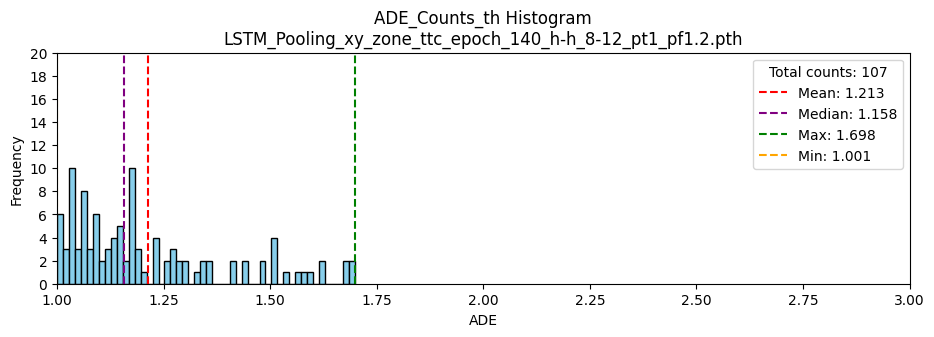

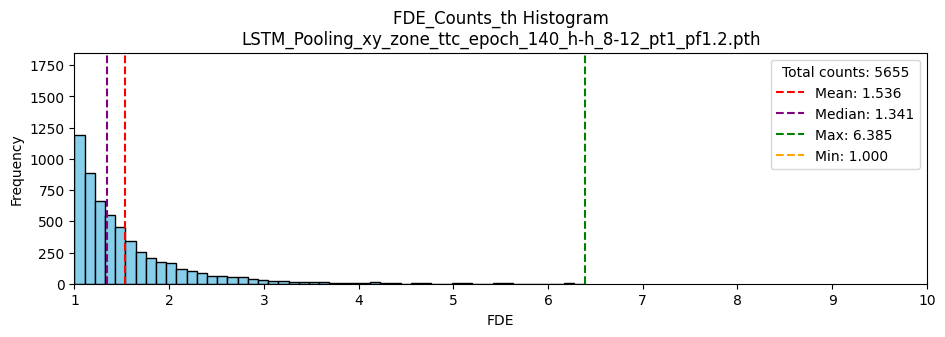

In [17]:
max_value_roundup_ade=np.ceil(np.max(ade_list_eval_test_extremes))
print('max_value_roundup_ade:', max_value_roundup_ade)
max_value_roundup_fde=np.ceil(np.max(fde_list_eval_test_extremes))
print('max_value_roundup_fde:', max_value_roundup_fde)

title1_ade=f'ADE_Counts_th Histogram'
# title2_ade = file_name_LSTM
title2_ade = file_name_LSTM_Pooling

title1_fde = f'FDE_Counts_th Histogram'
# title2_fde = file_name_LSTM
title2_fde = file_name_LSTM_Pooling

plot_histograms_ade_fde(ade_list_eval_test_extremes, 
                        fde_list_eval_test_extremes, 
                        title1_ade=title1_ade,
                        title2_ade=title2_ade,
                        title1_fde=title1_fde,
                        title2_fde=title2_fde,
                        bins=50, 
                        # x_interval_for_ade=[filter_threshold_for_extremes, max_value_roundup_ade],
                        # x_interval_for_fde=[filter_threshold_for_extremes, max_value_roundup_fde]
                        x_interval_for_ade=[filter_threshold_for_extremes, 3],
                        y_interval_for_ade=[0, 20],
                        x_interval_for_fde=[filter_threshold_for_extremes, 10],
                        y_interval_for_fde=[0, 1850]
                        )

# Histogram statistics

In [ ]:
def get_histogram_data(ade_list, fde_list, bins, density):
    arrays = [
    ['ADE', 'ADE', 'ADE','FDE', 'FDE', 'FDE'],
    ['bin_left', 'bin_right', 'value','bin_left', 'bin_right', 'value']]
    multi_index = pd.MultiIndex.from_arrays(arrays, names=('Metric', 'Edge'))
    hist_ade, bin_edges_ade = np.histogram(ade_list, bins=bins, density=density)
    hist_fde, bin_edges_fde = np.histogram(fde_list, bins=bins, density=density)
    df=pd.DataFrame([], columns=multi_index)
    df[('ADE', 'bin_left')] = bin_edges_ade[:-1]
    df[('ADE', 'bin_right')] = bin_edges_ade[1:]
    df[('ADE', 'value')] = hist_ade
    df[('FDE', 'bin_left')] = bin_edges_fde[:-1]
    df[('FDE', 'bin_right')] = bin_edges_fde[1:]
    df[('FDE', 'value')] = hist_fde
    return df

In [ ]:
df=get_histogram_data(ade_list_eval_test,fde_list_eval_test, bins=500, density=False)
# df

In [ ]:
# percent below mean 
below_mean_ade_percent = np.sum(ade_list_eval_test < eval_test['mean_ade'].numpy()) / len(ade_list_eval_test) * 100
print(f"below_mean_ade_percent:  {below_mean_ade_percent:.3f}")
below_mean_fde_percent = np.sum(fde_list_eval_test < eval_test['mean_fde'].numpy()) / len(fde_list_eval_test) * 100
print(f"below_mean_fde_percent:  {below_mean_fde_percent:.3f}")

below_mean_ade_percent:  65.315
below_mean_fde_percent:  65.242


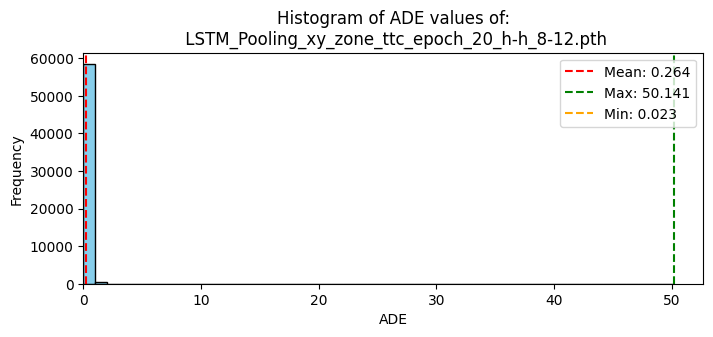

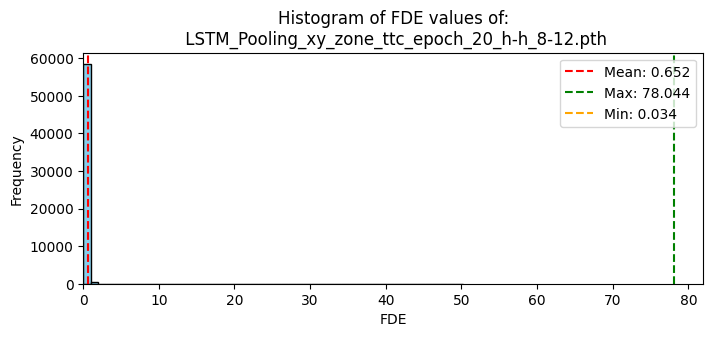

---------------------------→ → → → Zoom-in ← ← ← ←------------------------


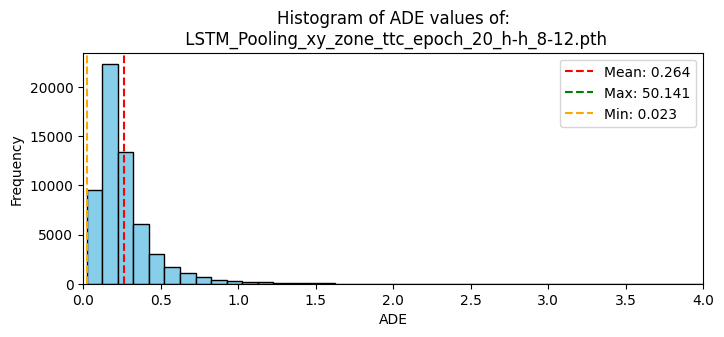

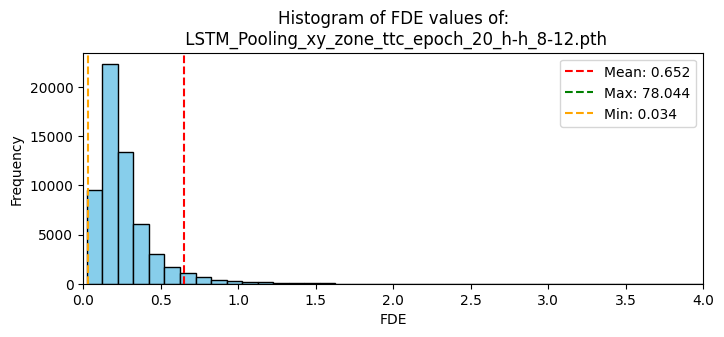

In [ ]:
plot_histograms_ade_fde(ade_list_eval_test, fde_list_eval_test, file_name_LSTM_Pooling, bins=50, x_interval=None)
print('---------------------------→ → → → Zoom-in ← ← ← ←------------------------')
plot_histograms_ade_fde(ade_list_eval_test, fde_list_eval_test, file_name_LSTM_Pooling, bins=500, x_interval=(0, 4))

# Stratified Analysis (SA)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_path = r'C:\Users\yftac\Documents\00_Project_Afeka\ttc_calculation\15_data_tcc_flattened_Stratified_Analysis'

# obs_input_len=8        # 8 history
# fut_output_len=12       # 12 horizon
# batch_size=64

SA_dataset = LoadCSV_to_Dataset(folder_path, obs_input_len, fut_output_len, 
                             input_features, output_features)   # loads csv's
SA_dataloader = DataLoader(SA_dataset,   batch_size, shuffle=False)

In [ ]:
# eval_SA = evaluate_model(model_EncDec_Noise_1, SA_dataloader, device)

# eval_SA=evaluate_model(model_LSTM, SA_dataloader, device)

eval_SA=evaluate_model(model_LSTM_Pooling, SA_dataloader, device)

# eval_SA = evaluate_model(model_TrajTransformer, SA_dataloader, device)

print('Avg. ADE/FDE:',eval_SA['mean_ade'], eval_SA['mean_fde'])

ade_list_SA = np.array([x.cpu().numpy() if torch.is_tensor(x) else x for x in eval_SA['ade_list']])
fde_list_SA = np.array([x.cpu().numpy() if torch.is_tensor(x) else x for x in eval_SA['fde_list']])
len(ade_list_SA), len(fde_list_SA)

Avg. ADE/FDE: tensor(1.0022) tensor(2.1782)


(23790, 23790)

In [ ]:
# get_histogram_data(ade_list_SA, fde_list_SA, bins=50, density=False)

In [ ]:
# percent below mean 
below_mean_ade_percent = np.sum(ade_list_SA < eval_SA['mean_ade'].numpy()) / len(ade_list_SA) * 100
print(f"below_mean_ade_percent:  {below_mean_ade_percent:.3f}")

below_mean_fde_percent = np.sum(fde_list_SA < eval_SA['mean_fde'].numpy()) / len(fde_list_SA) * 100
print(f"below_mean_fde_percent:  {below_mean_fde_percent:.3f}")

below_mean_ade_percent:  86.927
below_mean_fde_percent:  85.074


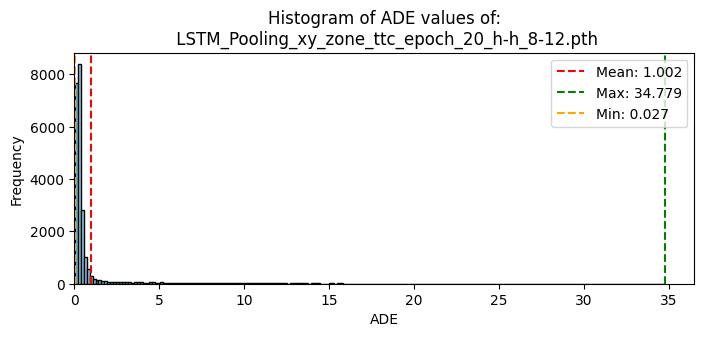

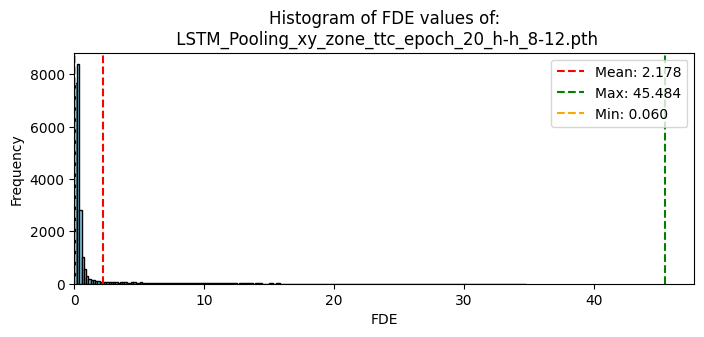

--------- Zoom-in ----------


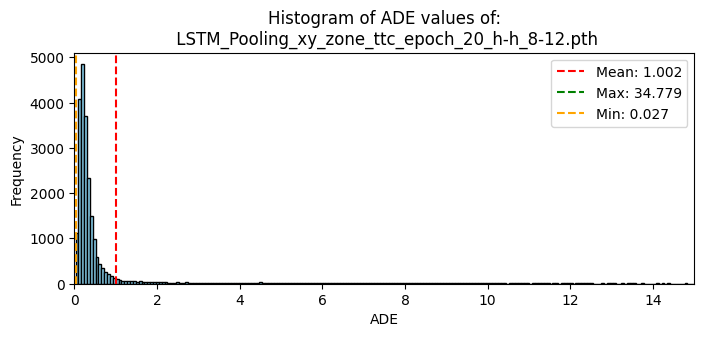

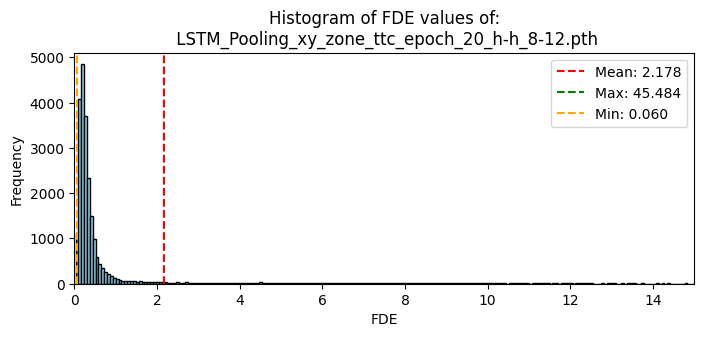

In [ ]:
plot_histograms_ade_fde(ade_list_SA, fde_list_SA, file_name_LSTM_Pooling, bins=200, x_interval=None)
print('--------- Zoom-in ----------')
plot_histograms_ade_fde(ade_list_SA, fde_list_SA, file_name_LSTM_Pooling, bins=500, x_interval=(0, 15))